In [44]:
import numpy as np
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn import preprocessing
from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
# from pandas.tools.plotting import table
# from __future__ import print_function

class Data: pass

In [45]:
class MyClassifier(object):
    def __init__(self):
        pass
    
    # read a tsv file 
    def read_tsv(self, fname):
        data = []
        labels = []
        f = open(fname, 'r')
        for line in f:
            (label,text) = line.strip().split("\t")
            labels.append(label)
            data.append(text)
        return data, labels
    
    # upload a train file (first column is label, second line is data)
    def upload_train_file(self, train_name):
        self.data = Data()
        stopWords = list((stopwords.words('english')))
        self.vectorizer = TfidfVectorizer(stop_words = stopWords, ngram_range=(1,2), min_df=2, \
                                          max_df=0.4, max_features=9000,smooth_idf=1)
    
        print("-- train data: ")
        self.data.train_data, self.data.train_labels = self.read_tsv(train_name)
        print(len(self.data.train_data))
        self.train_x = self.vectorizer.fit_transform(self.data.train_data)
        self.feature = self.vectorizer.get_feature_names()
        
        self.data.le = preprocessing.LabelEncoder()
        self.data.le.fit(self.data.train_labels)
        self.data.target_labels = self.data.le.classes_
        print(self.data.target_labels)
        self.train_y = self.data.le.transform(self.data.train_labels)
        
        self.explainer = LimeTextExplainer(class_names = self.data.target_labels)

    # upload a test file (first column is label, second line is data)
    # before calling this, must call upload_train_file
    def upload_test_file(self, test_name):
        print("-- test data: ")
        self.data.test_data, self.data.test_labels = self.read_tsv(test_name)
        print(len(self.data.test_data))
        self.test_x = self.vectorizer.transform(self.data.test_data)
        self.test_y = self.data.le.transform(self.data.test_labels)

    def extract_features(self, data):
        return self.vectorizer.transform(data)

    def train_model(self):
        print ("here train")
        pass
    
    def predict_sample(self, sample):
        pass
    
    def predict_test(self):
        pass
    
    def explain_self_input_sample(self, sample):
        print ("here")
        pass
    
    def explain_indexed_test_sample(self, idx):
        pass

In [46]:
class RandomForestClassifier(MyClassifier):
    def __init__(self):
        self.rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
    
    # before calling this function, must call self.upload_train_file
    def train_model(self):
        print ("train RandomForestClassifier")
        self.rf.fit(self.train_x, self.train_y)

    # before calling this function, must call self.upload_test_file
    def predict_test(self, figname = './tmp/static.png'):
        y_pred = self.rf.predict(self.test_x)
        precision, recall, fscore, support = sklearn.metrics.precision_recall_fscore_support(\
            self.test_y, y_pred, average = None, labels = [0,1])
        print("The precision is: ", precision)
        print("The recall is: ", recall)
        print("The f1-score is: ", fscore)
        n_classes = len(self.data.target_labels)
        names = self.data.target_labels
        data = []
        data.append(precision)
        data.append(recall)
        data.append(fscore)
        data = np.array(data).T
        df = pd.DataFrame(data, index = names, columns=['Precision','Recall','F1-Score'])
        the_table = plt.table(cellText=data, rowLabels=df.index, colLabels=df.columns, colWidths = [0.3]*data.shape[1], loc='center',cellLoc='center')
        the_table.set_fontsize(15)
        plt.axis('off')
        the_table.scale(1.5,1.52)
        plt.savefig(figname)
            
        
        y_score = self.rf.predict_proba(self.test_x)
        fpr, tpr, threshold = roc_curve(self.test_y, y_score[:,1]) 
        roc_auc = auc(fpr,tpr)
        plt.figure()
        lw = 2
        plt.figure(figsize=(10,10))
        plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.savefig('./tmp/roc.png')
        

    def predict_sample(self, sample):
        pred = self.rf.predict([sample])
        print("The lable of this sample is :" + str(self.data.target_labels[pred[0]]))
    
    def explain_indexed_test_sample(self, idx, num_of_features = 6, savefile='./tmp/local_res.html'):
        c = make_pipeline(self.vectorizer, self.rf)
        mydata = self.data.test_data[idx]
        exp = self.explainer.explain_instance(mydata, c.predict_proba, num_features = num_of_features)
        print('Sample id: %d' % idx)
        print('True class: %s' % self.data.target_labels[self.test_y[idx]])
        print('Predicted Class: %s' % self.data.target_labels[np.argmax(c.predict_proba([mydata]))])
        print('Probabilities = ',c.predict_proba([mydata]),'\n')
        print(exp.as_list(),"\n")
        exp.save_to_file(savefile)

    
    def explain_self_input_sample(self, sample, num_of_features = 6, savefile='./tmp/local_res.html'):
        print ("11111111111111111")
        c = make_pipeline(self.vectorizer, self.rf)
        print ("2222222222222222")
        mydata = sample
        exp = self.explainer.explain_instance(mydata, c.predict_proba, num_features = num_of_features)
        print('Predicted Class: %s' % self.data.target_labels[np.argmax(c.predict_proba([mydata]))])
        print('Probabilities = ',c.predict_proba([mydata]),'\n')
        print(exp.as_list(),"\n")
        exp.save_to_file(savefile)
    
    def get_top_features(self, n = 10):
        vec = self.rf.feature_importances_
        tmp = []
        for i in range(len(vec)):
            tmp.append([vec[i], i])
        tmp.sort(reverse = True)
        print("The top-%d important Feature Name & Importance Value: \n" % n)
        for i in range(n):
            idx = tmp[i][1]
            importance_value = tmp[i][0]
            feature_name = self.feature[idx]
            print("%20s : %f \n " %(feature_name, importance_value))


class LogisticRegressionClassifier(MyClassifier):
    def __init__(self):
        self.lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, C=1.5)
    
    # before calling this function, must call self.upload_train_file
    def train_model(self):
        print ("train LogisticRegressionClassifier")
        self.lr.fit(self.train_x, self.train_y)

    # before calling this function, must call self.upload_test_file
    def predict_test(self):
        pred = self.lr.predict(self.test_x)
        print("The F1-score is: ")
        print(sklearn.metrics.f1_score(self.test_y, pred, average='binary'))
    
    def predict_sample(self, sample):
        pred = self.lr.predict([sample])
        print("The lable of this sample is :" + str(self.data.target_labels[pred[0]]))
    
    def explain_indexed_test_sample(self, idx, num_of_features = 6, savefile='./tmp/local_res.html'):
        c = make_pipeline(self.vectorizer, self.lr)
        mydata = self.data.test_data[idx]
        exp = self.explainer.explain_instance(mydata, c.predict_proba, num_features = num_of_features)
        print('Sample id: %d' % idx)
        print('True class: %s' % self.data.target_labels[self.test_y[idx]])
        print('Predicted Class: %s' % self.data.target_labels[np.argmax(c.predict_proba([mydata]))])
        print('Probabilities = ',c.predict_proba([mydata]),'\n')
        print(exp.as_list(),"\n")
        exp.save_to_file(savefile)

    
    def explain_self_input_sample(self, sample, num_of_features = 6, savefile='./tmp/local_res.html'):
        c = make_pipeline(self.vectorizer, self.lr)
        mydata = sample
        exp = self.explainer.explain_instance(mydata, c.predict_proba, num_features = num_of_features)
        print('Predicted Class: %s' % self.data.target_labels[np.argmax(c.predict_proba([mydata]))])
        print('Probabilities = ',c.predict_proba([mydata]),'\n')
        print(exp.as_list(),"\n")
        exp.save_to_file(savefile)

    def get_top_features(self, n = 10):
        vec = abs(self.lr.coef_[0])
        tmp = []
        for i in range(len(vec)):
            tmp.append([vec[i], self.lr.coef_[0][i], i])
        tmp.sort(reverse = True)
        print("The top-%d important Feature Name & Importance Value: \n" % n)
        for i in range(n):
            idx = tmp[i][2]
            importance_value = tmp[i][1]
            feature_name = self.feature[idx]
            print("%20s : %f \n " %(feature_name, importance_value))

-- train data: 
4582
['NEGATIVE' 'POSITIVE']
-- test data: 
458
train RandomForestClassifier
The precision is:  [0.70656371 0.76884422]
The recall is:  [0.79912664 0.66812227]
The f1-score is:  [0.75       0.71495327]
Sample id: 100
True class: POSITIVE
Predicted Class: POSITIVE
Probabilities =  [[0. 1.]] 

[('Great', 0.2413745695475648), ('good', 0.20540942490945735), ('wings', -0.05519522287801443), ('20', -0.03854709329608112), ('played', 0.035134014072366514), ('chicken', 0.034039338970975774)] 



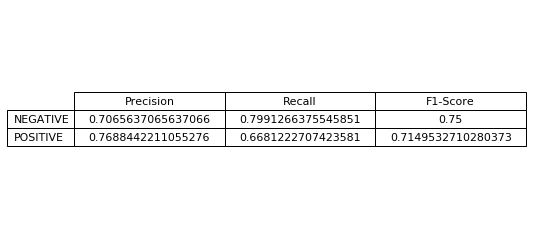

<Figure size 432x288 with 0 Axes>

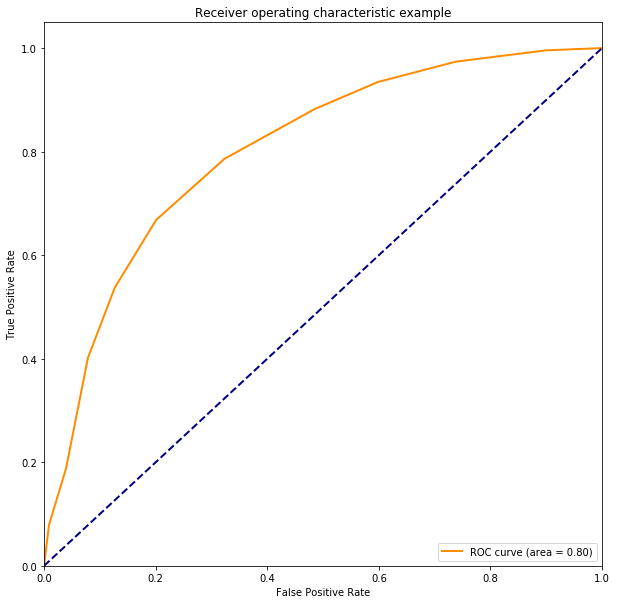

In [47]:
rf_classifier = RandomForestClassifier()
rf_classifier.upload_train_file("../train.tsv")
rf_classifier.upload_test_file("../test.tsv")
rf_classifier.train_model()
rf_classifier.predict_test()
rf_classifier.explain_indexed_test_sample(100)